In [1]:
!pip install emoji
!pip install contractions
!pip install gensim

In [34]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")
from typing import Optional

import seaborn as sns
import matplotlib.pyplot as plt

import re
import emoji
import contractions
import unicodedata
import gensim.downloader as api
from tokenizers import BertWordPieceTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

#For Training
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

import os
import ssl


import joblib

#For HyperParamerts tuning
from sklearn.model_selection import RandomizedSearchCV

In [3]:
url="https://media.githubusercontent.com/media/arpitmishra447/suicidal_message_classifier/refs/heads/main/dataset/Suicide_Detection.csv"
df=pd.read_csv(url)

In [4]:
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [6]:
df.shape

(232074, 3)

In [7]:
df.isnull().sum()

,0
Unnamed: 0,0
text,0
class,0


In [8]:
df.duplicated().sum()

0

In [9]:
df.drop(columns=["Unnamed: 0"],inplace=True)

In [10]:
df.columns

Index(['text', 'class'], dtype='object')

In [11]:
df.rename(columns={"class":"label"},inplace=True)

In [12]:
df["label"].value_counts()

,count
label,
suicide,116037
non-suicide,116037


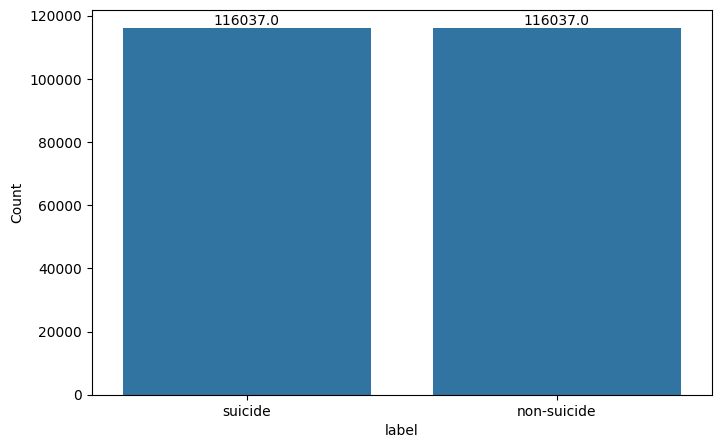

In [13]:
counts = df['label'].value_counts().reset_index()
counts.columns = ['label', 'Count']

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='label', y='Count', data=counts)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.show()

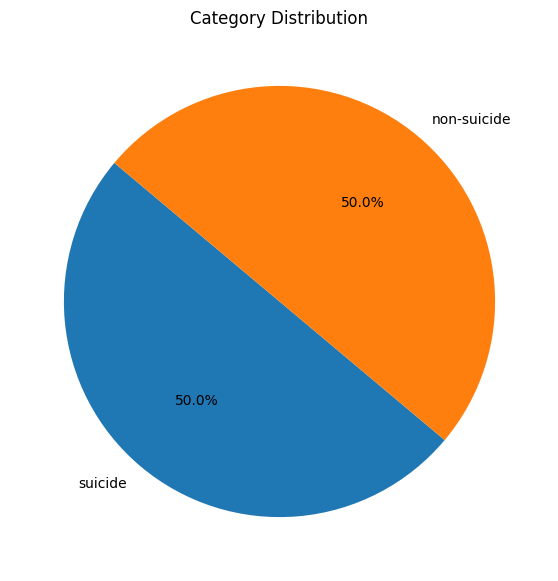

In [14]:
plt.figure(figsize=(7, 7))
plt.pie(df['label'].value_counts(),labels=['suicide','non-suicide'], autopct='%1.1f%%', startangle=140)

plt.title('Category Distribution')
plt.show()

In [15]:
df["label"]=df["label"].map({"suicide":1,"non-suicide":0})
label_map={"suicide":1,"non-suicide":0}

In [16]:
def remove_unusual_unicode_but_keep_emojis(text):
    return ''.join(c for c in text if ord(c) <= 0xFFFF or emoji.is_emoji(c))
def safe_expand_contractions(text):
    try:
        text = text.replace("İ", "I")
        text = remove_unusual_unicode_but_keep_emojis(text)
        return contractions.fix(text)
    except Exception as e:
        print(f"[EXPANSION ERROR] {e} | text: {text[:100]}")
        return text

In [17]:
def clean_text(text, keep_emojis=True):
    try:
        # Normalize Unicode (cleans up 'İ' or curly quotes)
        text = unicodedata.normalize("NFKC", text)

        # Expand contractions safely
        text = safe_expand_contractions(text)

        # Lowercase after expansion (to preserve casing rules first)
        text = text.lower()

        # Emoji handling
        if keep_emojis:
            text = emoji.demojize(text, delimiters=(" ", " "))
        else:
            text = emoji.replace_emoji(text, "")

        # Replace URLs with token
        text = re.sub(r"http\S+|www\S+|https\S+", "<url>", text)

        # Add space around punctuation
        text = re.sub(r"([\"\'\.\(\)\!\?\-\\\/\,])", r" \1 ", text)

        # Normalize whitespace
        return " ".join(text.split())

    except Exception as e:
        print(f"[CLEAN_TEXT ERROR] {e} | text: {text[:100]}")
        return "<MALFORMED>"

In [18]:
print(clean_text("i don't want to live anymore i want to stop it for good😭😭"))

i do not want to live anymore i want to stop it for good loudly_crying_face loudly_crying_face


In [19]:
df['cleaned_text'] = df['text'].apply(clean_text)

In [20]:
df.head()

,text,label,cleaned_text
0,Ex Wife Threatening SuicideRecently I left my ...,1,ex wife threatening suiciderecently i left my ...
1,Am I weird I don't get affected by compliments...,0,am i weird i do not get affected by compliment...
2,Finally 2020 is almost over... So I can never ...,0,finally 2020 is almost over . . . so i can nev...
3,i need helpjust help me im crying so hard,1,i need helpjust help me i am crying so hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",1,"i am so losthello , my name is adam ( 16 ) and..."


In [21]:
class FeatureEngineer:
    def __init__(self):
        # Precompiled regex patterns
        self.crisis_pat = re.compile(
            r"(i want to die|i want to kill myself|i am going to end my life|i have nothing left|"
            r"goodbye forever|no reason to live|i cannot do this anymore|ending it all|"
            r"final goodbye|life is meaningless|i am done living|i do not want to live anymore)",
            flags=re.IGNORECASE
        )
        self.self_ref_pat = re.compile(r'\b(i|me|my|myself)\b', flags=re.IGNORECASE)
        self.negation_pat = re.compile(r'\b(no|not|never|nothing)\b', flags=re.IGNORECASE)

    def extract_features(self, series: pd.Series) -> np.ndarray:
        """Vectorized feature extraction using pandas string methods"""
        # Lowercase for consistency
        series = series.astype(str).str.lower()

        features = pd.DataFrame()
        features['crisis_count'] = series.str.count(self.crisis_pat)
        features['self_ref'] = series.str.count(self.self_ref_pat)
        features['negations'] = series.str.count(self.negation_pat)
        features['char_count'] = series.str.len()
        features['word_count'] = series.str.split().str.len()
        features['exclamation_count'] = series.str.count(r'!')
        features['question_count'] = series.str.count(r'\?')
        features['ellipsis_count'] = series.str.count(r'\.\.\.')

        return features.to_numpy(dtype=np.float32)
# Initialize
fe= FeatureEngineer()

In [22]:
extra_features=fe.extract_features(df["cleaned_text"])

In [23]:
extra_features

array([[ 0., 16.,  1., ...,  0.,  2.,  0.],
       [ 0.,  4.,  1., ...,  0.,  0.,  0.],
       [ 0.,  2.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  4.,  0.,  0.],
       [ 0., 44., 12., ...,  0.,  0.,  0.],
       [ 0.,  4.,  1., ...,  0.,  0.,  0.]], dtype=float32)

In [24]:
def sentence_to_vector(text, model, tokenizer):
    # Use the new tokenizer and get the tokens
    tokens = tokenizer.encode(str(text)).tokens
    # Filter out special tokens like [CLS], [SEP] before looking up in GloVe
    tokens = [word for word in tokens if word not in ['[CLS]', '[SEP]']]

    word_vectors = [model[word] for word in tokens if word in model.key_to_index]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [25]:
glove_model = api.load('glove-wiki-gigaword-100')
vocab_file = 'bert-base-uncased-vocab.txt'
if not os.path.exists(vocab_file):
    print(f"Vocabulary file '{vocab_file}' not found. Downloading...")
    # This command fetches the standard vocabulary file for BERT.
    !wget https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt
    print("Download complete.")
else:
    print(f"Vocabulary file '{vocab_file}' already exists.")

print("Loading self-contained tokenizer from vocabulary file...")
tokenizer = BertWordPieceTokenizer(vocab_file, lowercase=True)
print("Tokenizer loaded successfully.")

[==================================================] 100.0% 128.1/128.1MB downloaded
Vocabulary file 'bert-base-uncased-vocab.txt' not found. Downloading...
--2025-07-18 06:22:48--  https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.228.232, 52.216.58.160, 52.217.202.192, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.228.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231508 (226K) [text/plain]
Saving to: ‘bert-base-uncased-vocab.txt’

bert-base-uncased-v 100%[===================>] 226.08K   417KB/s    in 0.5s    

2025-07-18 06:22:50 (417 KB/s) - ‘bert-base-uncased-vocab.txt’ saved [231508/231508]

Download complete.
Loading self-contained tokenizer from vocabulary file...
Tokenizer loaded successfully.


In [26]:
df['glove_vector'] = df['cleaned_text'].apply(lambda x: sentence_to_vector(x, glove_model, tokenizer))

In [27]:
df.head()

,text,label,cleaned_text,glove_vector
0,Ex Wife Threatening SuicideRecently I left my ...,1,ex wife threatening suiciderecently i left my ...,"[-0.025708398, 0.19325893, 0.4012117, -0.30566..."
1,Am I weird I don't get affected by compliments...,0,am i weird i do not get affected by compliment...,"[-0.03894744, 0.33328754, 0.55440134, -0.44038..."
2,Finally 2020 is almost over... So I can never ...,0,finally 2020 is almost over . . . so i can nev...,"[-0.118019365, 0.26424903, 0.5311021, -0.40274..."
3,i need helpjust help me im crying so hard,1,i need helpjust help me i am crying so hard,"[-0.1092759, 0.4444979, 0.351438, -0.32560727,..."
4,"I’m so lostHello, my name is Adam (16) and I’v...",1,"i am so losthello , my name is adam ( 16 ) and...","[-0.040165287, 0.2106677, 0.35624766, -0.30224..."


In [28]:
ss=StandardScaler()
ss.fit_transform(extra_features)
joblib.dump(ss,'ss_model.joblib')

['ss_model.joblib']

In [29]:
X_glove = np.vstack(df['glove_vector'].values)
X_combined = np.hstack([X_glove, extra_features])
y = df['label'].values

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Linear SVM": LinearSVC(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=300, class_weight={0:1, 1:2}, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGboost": XGBClassifier(random_state=42)
}

In [32]:
for name, model in models.items():
    print(f"\n Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Non-Suicidal', 'Suicidal']))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


 Training: Logistic Regression
Accuracy: 0.8708
Classification Report:
               precision    recall  f1-score   support

Non-Suicidal       0.88      0.86      0.87     23208
    Suicidal       0.87      0.88      0.87     23207

    accuracy                           0.87     46415
   macro avg       0.87      0.87      0.87     46415
weighted avg       0.87      0.87      0.87     46415

Confusion Matrix:
 [[20032  3176]
 [ 2820 20387]]

 Training: Linear SVM
Accuracy: 0.8703
Classification Report:
               precision    recall  f1-score   support

Non-Suicidal       0.88      0.86      0.87     23208
    Suicidal       0.86      0.88      0.87     23207

    accuracy                           0.87     46415
   macro avg       0.87      0.87      0.87     46415
weighted avg       0.87      0.87      0.87     46415

Confusion Matrix:
 [[19982  3226]
 [ 2793 20414]]

 Training: Random Forest
Accuracy: 0.8753
Classification Report:
               precision    recall  f1-scor

In [35]:
# Baseline XGBoost Model

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],      # Fraction of training data to use for each tree
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0], # Fraction of features to use for each tree
    'gamma': [0, 0.1, 0.2, 0.5]              # Regularization parameter
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=25,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2, # Set to 2 to see progress
    random_state=42
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300, 500],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='f1_weighted', verbose=2)


--- Tuning Results ---
Best cross-validation F1-score: 0.9056
Best parameters found:
{'subsample': 0.7, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}

--- Final Evaluation Report on Test Set (using best model) ---
accuracy: 0.9085424970375956
              precision    recall  f1-score   support

           0       0.90      0.91      0.91     23208
           1       0.91      0.90      0.91     23207

    accuracy                           0.91     46415
   macro avg       0.91      0.91      0.91     46415
weighted avg       0.91      0.91      0.91     46415



<Axes: >

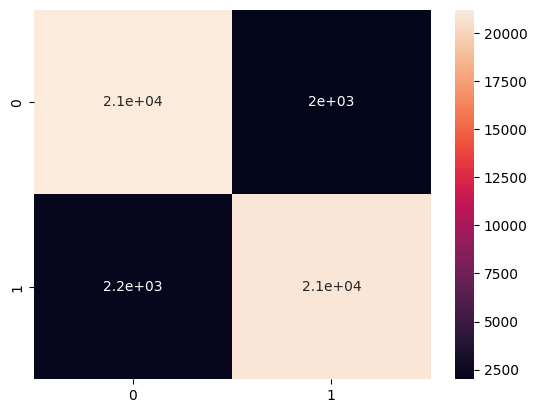

In [40]:
print("\n--- Tuning Results ---")
print(f"Best cross-validation F1-score: {random_search.best_score_:.4f}")
print("Best parameters found:")
print(random_search.best_params_)

best_xgb_model = random_search.best_estimator_

print("\n--- Final Evaluation Report on Test Set (using best model) ---")
y_pred_tuned = best_xgb_model.predict(X_test)
print("accuracy:",accuracy_score(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))
sns.heatmap(confusion_matrix(y_test, y_pred_tuned),annot=True)

In [37]:
joblib.dump(best_xgb_model, 'xgb_tuned_model.joblib')

['xgb_tuned_model.joblib']